In [1]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split


SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [3]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [4]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 1167.13it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [5]:
from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
resampled_len = 450000
len_128 = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_128):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/len_128)

df.head()


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:07<00:00,  8.55it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[-3.3908420959960495e-08, 0.011314918287098408...","[0.08000000566244125, 0.08619667589664459, 0.0...","[56, 214, 373, 531, 689, 845, 1003, 1162, 1320...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.034999970346689224, -0.04483037441968918, ...","[-0.0950000062584877, -0.109402135014534, -0.1...","[93, 298, 474, 687, 859, 1068, 1242, 1449, 162...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.5600001215934753, -0.57822585105896, -0.56...","[0.4300000071525574, 0.4723737835884094, 0.564...","[177, 408, 636, 769, 1048, 1275, 1455, 1703, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.460000216960907, -0.47652408480644226, -0....","[0.5600000023841858, 0.6865580081939697, 0.605...","[191, 435, 681, 925, 1169, 1417, 1666, 1914, 2...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27000004053115845, -0.5269216299057007, -0...","[-0.019999966025352478, 0.03706035017967224, -...","[52, 248, 439, 632, 826, 1021, 1216, 1410, 160...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


# center the signals in 0 mean 
ids = df.index.tolist()

for id in tqdm(ids):
    row = df.iloc[id]
    sign1 = np.asarray(row['ecg_lead_1'])
    sign2 = np.asarray(row['ecg_lead_2'])
    sign1 = (sign1 - sign1.mean()).tolist()
    sign2 = (sign2 - sign2.mean()).tolist()
    df.iloc[id]['ecg_lead_1'] = sign1[:]
    df.iloc[id]['ecg_lead_1'] = sign2[:]

In [6]:
# split validation and training 
validation_percentage = 0.1
training_df, validation_df = train_test_split(df,test_size = validation_percentage,random_state=SEED)

Count classes

Create dataset 

In [7]:
classes = np.array(["N","S","V"])

patch_length = 450

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df.index.tolist()
    print(ids)
    for l,id in enumerate(ids):
        print(f"{l}/{len(ids)}",end='\r')
        row =  df.loc[id]

        peaks = row['peaks']
        first_lead_signal = row['ecg_lead_1']
        second_lead_signal = row['ecg_lead_2']
        
        if(len(peaks) != len(labels[id])):
            print("ERROR")

        for i,peak in enumerate(peaks):

            dataset_dict[str(id)+'_'+str(i)] = {}
            dataset_dict[str(id)+'_'+str(i)]["first_lead"] = list()
            dataset_dict[str(id)+'_'+str(i)]["second_lead"] = list()

            size = list(range(int(peak-patch_length/2),int(peak+patch_length/2)))
            if(len(size) != patch_length):
                print("error")

            for s in size:
                if(s < 0 or s >= resampled_len):   # padding with 0
                    dataset_dict[str(id)+'_'+str(i)]["first_lead"].append(0.) 
                    dataset_dict[str(id)+'_'+str(i)]["second_lead"].append(0.) 
                else:
                    dataset_dict[str(id)+'_'+str(i)]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[str(id)+'_'+str(i)]["second_lead"].append(second_lead_signal[s])

            dataset_dict[str(id)+'_'+str(i)]["stringLabel"] = labels[id][i]
            dataset_dict[str(id)+'_'+str(i)]["label"] = convert_to_one_hot(labels[id][i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df

In [8]:
training_patches_df = create_patch_dataset(training_df)
validation_patches_df = create_patch_dataset(validation_df)

[81, 92, 82, 33, 89, 104, 69, 17, 73, 48, 83, 67, 53, 58, 55, 87, 85, 59, 36, 10, 2, 32, 70, 19, 27, 44, 62, 98, 100, 40, 46, 56, 78, 23, 34, 91, 94, 102, 15, 88, 41, 51, 45, 96, 52, 26, 103, 43, 97, 24, 4, 66, 74, 49, 21, 3, 30, 47, 80, 8, 60, 0, 95, 57, 22, 61, 63, 7, 101, 13, 68, 90, 14, 29, 28, 11, 84, 18, 20, 50, 25, 6, 71, 76, 1, 16, 64, 79, 5, 75, 9, 72, 12, 37]
[65, 35, 42, 93, 38, 39, 54, 86, 31, 77, 99]


In [9]:
# count classes 


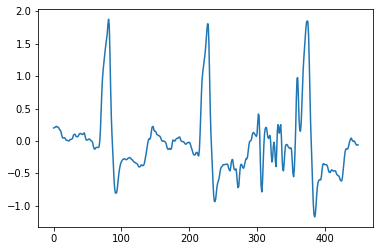

In [10]:
def plot_patch(num):
    fig,ax = plt.subplots()
    y = training_patches_df.iloc[num]['first_lead']
    x = list(range(len(y)))
    ax.plot(x,y)
    plt.show()
    
plot_patch(61)

In [ ]:
import random
BALANCE = 1

# to balance classes we may want to drop at least 216k normal beats in input
if(BALANCE):
    num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
    num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
    num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
    to_drop = num_n - max(num_s,num_v)
else:
    to_drop = 0

ids_to_drop = list()

ids = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist() #ids where label is = 'N'
random.shuffle(ids)
ids_to_drop = ids[:to_drop]

training_patches_df = training_patches_df.drop(ids_to_drop)
training_patches_df.head()


,first_lead,second_lead,stringLabel,label
81_12,"[-0.405, -0.415, -0.43, -0.435, -0.43, -0.44, ...","[0.365, 0.36, 0.345, 0.33, 0.325, 0.32, 0.31, ...",S,"[0.0, 1.0, 0.0]"
81_15,"[-0.21, -0.23, -0.24, -0.245, -0.25, -0.265, -...","[0.47, 0.46, 0.44, 0.43, 0.43, 0.425, 0.42, 0....",S,"[0.0, 1.0, 0.0]"
81_21,"[-0.23, -0.24, -0.245, -0.25, -0.255, -0.265, ...","[0.5, 0.495, 0.495, 0.5, 0.505, 0.52, 0.515, 0...",S,"[0.0, 1.0, 0.0]"
81_35,"[-0.41, -0.41, -0.41, -0.39, -0.34, -0.275, -0...","[0.135, 0.135, 0.13, 0.13, 0.125, 0.13, 0.15, ...",S,"[0.0, 1.0, 0.0]"
81_41,"[-0.49, -0.48, -0.45, -0.415, -0.4, -0.4, -0.4...","[0.23, 0.165, 0.14, 0.16, 0.205, 0.22, 0.215, ...",S,"[0.0, 1.0, 0.0]"


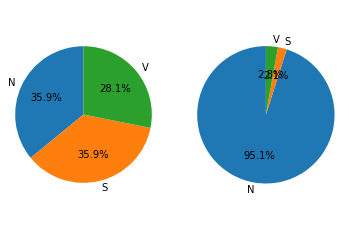

In [ ]:
training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [ ]:
def create_input(df):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        y.append(row['label'])

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    
    return x,y

In [ ]:
x_train,y_train = create_input(training_patches_df)
x_valid,y_valid = create_input(validation_patches_df)

100%|█████████████████████████████████████████████████████████████████████████| 22627/22627 [00:01<00:00, 14165.15it/s]


In [ ]:
patch_length

450

In [ ]:
import seaborn as sns
from keras.utils.vis_utils import plot_model
from math import gcd
from sklearn.utils.class_weight import compute_class_weight

batch_size = 128
max_patch_length = patch_length 

def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = keras.layers.Conv1D(num_filters, kernel_size=9, strides = 2,  padding = 'same')(block_input) 
    block_input = keras.layers.BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=9, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)  
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=9, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = keras.layers.Conv1D(filters=num_filters, kernel_size=9, padding= 'same')(block_input)
    norm1 = keras.layers.BatchNormalization()(conv1)
    relu1 = keras.layers.Activation('relu')(norm1)    
    dropout = keras.layers.Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = keras.layers.Conv1D(num_filters, kernel_size=9, padding= 'same')(dropout) #per avere concordanza
    norm2 = keras.layers.BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = keras.layers.Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = keras.layers.Activation('relu')(sum)
    
    return relu2 

#N= number of blocks in resnet, ch = different channels, win_len = common lenght for ecg signals, classes=..
def resnet(N=8, custom_loss = None): 
    ecg_input = keras.layers.Input(shape=(max_patch_length,2), name='ecg_signal') 

    ResNet = keras.layers.Conv1D(filters=64,kernel_size=17, padding = 'same')(ecg_input) 
    ResNet = keras.layers.BatchNormalization()(ResNet)
    ResNet = keras.layers.Activation('relu')(ResNet)
    ResNet = keras.layers.MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = keras.layers.GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    #Not necessary?
    #ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer to retrieve all the combination, instead of softmax
    ResNet = keras.layers.Dense(3, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = tf.keras.Model(inputs=[ecg_input],outputs=ResNet)

    # summarize layers
    print(model.summary())
    # plot graph
    #plot_model(model, to_file='convolutional_neural_network.png')
    return model

nn= resnet()

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,
    mode="auto",
    restore_best_weights=False,
)


learning_rate = 1e-5
nn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['Precision', 'Recall'],
    
)
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = np.unique(y_integers), 
                                            y = y_integers 
                                        )
d_class_weights = dict(enumerate(class_weights))

history = nn.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history

#validation_data=(X_val_filt, y_val),

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ecg_signal (InputLayer)        [(None, 450, 2)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 450, 64)      2240        ['ecg_signal[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 450, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 450, 64)      0           ['batch_normalization[0][0]']

198/198 [==============================] - 118s 550ms/step - loss: 0.6247 - precision: 0.8394 - recall: 0.7668 - val_loss: 0.2144 - val_precision: 0.9545 - val_recall: 0.9472
Epoch 2/100
198/198 [==============================] - 109s 550ms/step - loss: 0.2133 - precision: 0.9358 - recall: 0.9280 - val_loss: 0.2545 - val_precision: 0.9297 - val_recall: 0.9280
Epoch 3/100
198/198 [==============================] - 110s 555ms/step - loss: 0.1662 - precision: 0.9485 - recall: 0.9431 - val_loss: 0.4129 - val_precision: 0.9136 - val_recall: 0.9117
Epoch 4/100
198/198 [==============================] - 111s 557ms/step - loss: 0.1357 - precision: 0.9573 - recall: 0.9540 - val_loss: 0.2144 - val_precision: 0.9235 - val_recall: 0.9211
Epoch 5/100
198/198 [==============================] - 110s 555ms/step - loss: 0.1353 - precision: 0.9576 - recall: 0.9545 - val_loss: 0.0905 - val_precision: 0.9697 - val_recall: 0.9685
Epoch 6/100
198/198 [==============================] - 109s 548ms/step - loss

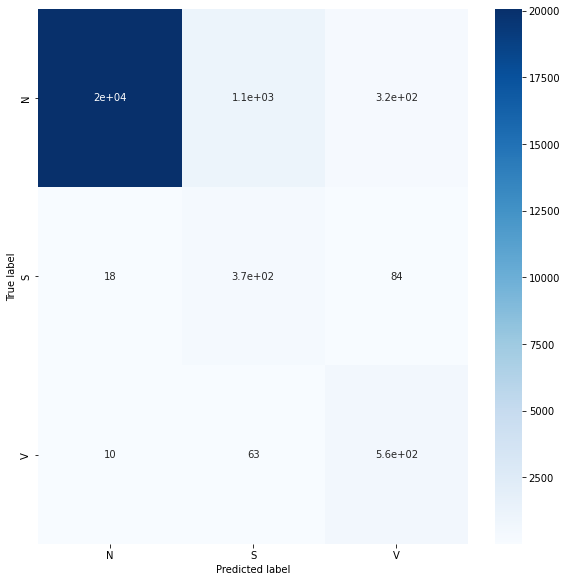

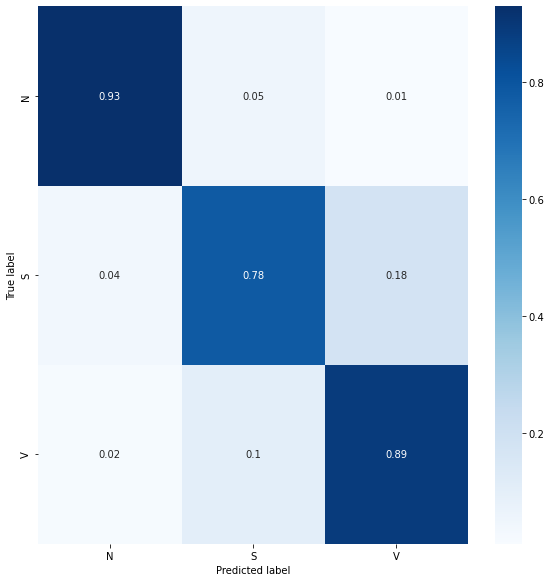

In [ ]:


# take also old samples to assess performances 
def plot_confusion_matrix(y_true, y_pred,normalized):
    """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
    """
    con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
    if (normalized):
      con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
      con_mat_df = pd.DataFrame(con_mat_norm,
                      index = classes, 
                      columns = classes)
    else:
        con_mat_df = pd.DataFrame(con_mat,
                      index = classes, 
                      columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return con_mat


print("Making predictions ...",end="\r")

y_pred= nn.predict(x_valid)

y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

conf = plot_confusion_matrix(y_val_classes, y_pred,0)
conf = plot_confusion_matrix(y_val_classes, y_pred,1)

In [ ]:
print(conf)

classes = ["N","S","V"]

results = {}

for i,c in enumerate(classes):
    
    results[c] = {}
    
    others = [0,1,2]
    others.remove(i)
    
    results[c]["tp"] = conf[i,i]
    results[c]["fn"] = 0
    results[c]["fp"] = 0
    
    for l in others:
        results[c]["fn"] += conf[i,l]
        results[c]["fp"] += conf[l,i]


sensitivity_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fn"])
precision_n = (results["N"]["tp"])/(results["N"]["tp"]+results["N"]["fp"])

print(f"sensitivity for N: {sensitivity_n}")
print(f"precision for N: {precision_n}")

sensitivity_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fn"])
precision_s = (results["S"]["tp"])/(results["S"]["tp"]+results["S"]["fp"])

print(f"sensitivity for S: {sensitivity_s}")
print(f"precision for S: {precision_s}")

sensitivity_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fn"])
precision_v = (results["V"]["tp"])/(results["V"]["tp"]+results["V"]["fp"])

print(f"sensitivity for V: {sensitivity_v}")
print(f"precision for V: {precision_v}")

[[20074  1125   319]
 [   18   369    84]
 [   10    63   565]]
sensitivity for N: 0.9328933915791431
precision for N: 0.9986071037707691
sensitivity for S: 0.7834394904458599
precision for S: 0.23699421965317918
sensitivity for V: 0.8855799373040752
precision for V: 0.5836776859504132
